In [ ]:
# Allmäna imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold # Added RandomizedSearchCV and StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# För evaluering
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from scipy.stats import uniform, randint # Needed for RandomizedSearchCV distributions

df = pd.read_parquet('train_delay_data.parquet')

In [10]:
df

,AdvertisedTrainIdent,TripStartDate,LocationSignatureDeparture,LocationSignatureArrival,DepartureAdvertised,DepartureActual,ArrivalAdvertised,ArrivalActual,DelayMinutes,DurationActualMinutes,...,arrival_station,end_station_county,Deviation_Description,start_hour,start_day_of_month,start_month,is_weekday,is_delayed,DayOfWeek,PlanedDuration
0,10994,2025-10-09,Cst,U,2025-10-09 22:11:00,2025-10-09 22:11:24,2025-10-09 22:51:00,2025-10-09 22:49:17,-2,38,...,Uppsala central,Uppsala län,None,22,9,10,1,0,3,40.0
1,1154,2025-10-09,Mc,Hb,2025-10-09 22:12:00,2025-10-09 22:12:51,2025-10-09 22:53:00,2025-10-09 22:52:44,0,40,...,Helsingborgs central,Skåne län,None,22,9,10,1,0,3,41.0
2,1156,2025-10-09,Hie,Lu,2025-10-09 22:18:00,2025-10-09 22:18:43,2025-10-09 22:40:00,2025-10-09 22:39:13,-1,20,...,Lund c,Skåne län,None,22,9,10,1,0,3,22.0
3,1160,2025-10-09,Hie,Lu,2025-10-09 22:48:00,2025-10-09 22:48:21,2025-10-09 23:09:00,2025-10-09 23:11:39,3,23,...,Lund c,Skåne län,None,22,9,10,1,0,3,21.0
4,1162,2025-10-09,Hie,Lu,2025-10-09 23:03:00,2025-10-09 23:03:22,2025-10-09 23:22:00,2025-10-09 23:22:53,1,20,...,Lund c,Skåne län,None,23,9,10,1,0,3,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32699,977,2025-10-22,U,Öb,2025-10-22 18:08:00,2025-10-22 18:08:42,2025-10-22 20:49:00,2025-10-22 20:47:32,-1,159,...,Örebro södra,Örebro län,None,18,22,10,1,0,2,161.0
32700,982,2025-10-22,Öb,U,2025-10-22 18:09:00,2025-10-22 18:11:44,2025-10-22 20:49:00,2025-10-22 20:54:01,5,162,...,Uppsala central,Uppsala län,None,18,22,10,1,1,2,160.0
32701,988,2025-10-22,Arb,U,2025-10-22 19:34:00,2025-10-22 20:00:12,2025-10-22 21:49:00,2025-10-22 22:08:35,20,128,...,Uppsala central,Uppsala län,None,19,22,10,1,1,2,135.0
32702,989,2025-10-22,U,Et,2025-10-22 20:09:00,2025-10-22 20:09:53,2025-10-22 21:56:00,2025-10-22 21:53:34,-2,104,...,Eskilstuna central,Södermanlands län,None,20,22,10,1,0,2,107.0


In [2]:
datetime_cols = ['TripStartDate']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
df['DayOfWeek'] = df['TripStartDate'].dt.dayofweek

df['PlanedDuration'] = (df['ArrivalAdvertised'] - df['DepartureAdvertised']).dt.total_seconds() / 60.0

In [3]:
def define_feature_groups(df):
    """Defines which columns belong to which processing group."""
    
    # Numerical features that are right-skewed and need transformation
    numerical_features = ['DistanceKm', 'PlanedDuration']
    
    # Nominal categorical features (including those with NaNs)
    nominal_categorical_features = [
        'departure_station', 'arrival_station', 'end_station_county',
        'TrainOwner', 'Operator', 'trip_typeoftraffic',
        'DayOfWeek', 'start_hour' # Treat DayOfWeek and start_hour as nominal for OHE
    ]

    # Binary/Ordinal features that require minimal processing (or none)
    binary_features = ['is_weekday'] 
    
    return numerical_features, nominal_categorical_features, binary_features

In [4]:

def build_preprocessor(numerical_features, nominal_categorical_features, binary_features):
    """
    Creates a ColumnTransformer to apply different preprocessing steps
    to different columns.
    """
    # Pipeline for Numerical Features (DistanceKm, PlanedDuration)
    # 1. PowerTransformer handles the right-skewed distribution.
    # 2. StandardScaler ensures features have zero mean and unit variance.
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    # Pipeline for Nominal Categorical Features
    # 1. Imputer fills missing values (e.g., in TrainOwner/Operator/trip_typeoftraffic)
    # 2. OneHotEncoder converts categories into binary features.
    categorical_pipeline = Pipeline(steps=[
        # Use 'most_frequent' for nominal data, fill_value='missing' works well for OHE
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # handle_unknown='ignore' ensures robustness against new categories in test set
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine all pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, nominal_categorical_features),
            ('bin', 'passthrough', binary_features) # No transformation needed for is_weekday
        ],
        remainder='drop' # Drop any other columns not specified
    )
    return preprocessor


In [5]:

def get_transformed_dataframe(df, preprocessor, nominal_categorical_features, numerical_features, binary_features):
    """
    Applies the preprocessor to the input DataFrame and returns a new DataFrame
    with proper column names, ready for visualization and inspection.
    """
    # 1. Fit and transform the data
    X_transformed = preprocessor.fit_transform(df.drop(columns=['is_delayed']))

    # 2. Extract feature names from the OneHotEncoder
    # Get the 'onehot' step from the 'cat' transformer
    ohe_step = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    # Get the names of the encoded columns
    feature_names_out = list(numerical_features)
    feature_names_out.extend(ohe_step.get_feature_names_out(nominal_categorical_features))
    feature_names_out.extend(binary_features)

    # 3. Create the final DataFrame
    transformed_df = pd.DataFrame(X_transformed, columns=feature_names_out)
    
    # 4. Add the target variable back (since we dropped it earlier)
    transformed_df['is_delayed'] = df['is_delayed'].values 
    
    print(f"\n--- Transformed DataFrame Dimensions for Visualization ---")
    print(f"Shape: {transformed_df.shape}")
    print(f"Columns: {len(transformed_df.columns)}")
    
    return transformed_df

In [7]:

df = df.copy()

X = df.drop('is_delayed', axis=1)
y = df['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features, nominal_categorical_features, binary_features = define_feature_groups(df)

preprocessor = build_preprocessor(numerical_features, nominal_categorical_features, binary_features)

# --- Step A: Visualization of Transformed Data (Skipped plotting for brevity in this update) ---

# Generate the visualization-ready DataFrame (still useful for context)
df_transformed = get_transformed_dataframe(
    df, 
    preprocessor, 
    nominal_categorical_features, 
    numerical_features, 
    binary_features
)

# 
print("\nVisualization and initial data prep complete.")

# --- Step B: Model Training and Hyperparameter Tuning ---

# 1. Define the base pipeline (Preprocessor -> Classifier)
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Initial model with a placeholder random_state
    ('classifier', XGBClassifier(use_label_encoder=False, 
                                    eval_metric='logloss',
                                    random_state=42,
                                    scale_pos_weight=4)
    ) 
])

# 2. Define the parameter grid for RandomizedSearchCV
# Note: Parameters are prefixed with the estimator name, e.g., 'classifier__max_depth'
# REVISED RANGES based on previous run's boundary hits:
param_distributions = {
    'classifier__n_estimators': randint(50, 500), # Unchanged
    'classifier__learning_rate': uniform(0.01, 0.3), # Unchanged
    'classifier__max_depth': randint(3, 15), # EXPANDED: from 3-10 to 3-15 (i.e., max depth up to 14)
    'classifier__colsample_bytree': uniform(0.4, 0.6), # EXPANDED: from 0.6-1.0 to 0.4-1.0 (start lower)
    'classifier__gamma': uniform(0, 1.0), # EXPANDED: from 0-0.5 to 0-1.0 (allow higher regularization)
}

# 3. Setup Cross-Validation
# Use StratifiedKFold to maintain the proportion of the target variable (is_delayed) in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Initialize and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_distributions,
    n_iter=50, # Number of parameter settings that are sampled (adjust based on resources)
    scoring='roc_auc', # Metric to optimize for (ROC AUC is good for imbalance)
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

print("\n" + "="*50)
print("--- STEP B: Starting Hyperparameter Tuning (Randomized Search) ---")
print("Optimization Metric: ROC AUC (Good for Imbalanced Data)")
print("="*50)

random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

print("\nHyperparameter tuning complete.")
print(f"Best ROC AUC Score found: {random_search.best_score_:.4f}")
print("\nBest Parameters Found:")
# Print only the classifier parameters for clarity
best_params_clean = {k.replace('classifier__', ''): v for k, v in random_search.best_params_.items()}
for k, v in best_params_clean.items():
    print(f"  {k}: {v:.4f}")
    
# 5. Evaluate the best model (Simple Accuracy)
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"\nTraining Accuracy (Best Model): {train_accuracy:.4f}")
print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

# --- Step C: Comprehensive Model Evaluation (using best_model) ---
print("\n" + "="*50)
print("--- STEP C: DETAILED MODEL EVALUATION (BEST MODEL ON TEST SET) ---")
print("="*50)

# 1. Generate predictions and probabilities for the test set
y_pred = best_model.predict(X_test)
# We need probabilities for the ROC curve (class 1: delayed)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 



--- Transformed DataFrame Dimensions for Visualization ---
Shape: (32704, 586)
Columns: 586

Visualization and initial data prep complete.

--- STEP B: Starting Hyperparameter Tuning (Randomized Search) ---
Optimization Metric: ROC AUC (Good for Imbalanced Data)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\karlt\Documents\ec_utbildning\DS_Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperparameter tuning complete.
Best ROC AUC Score found: 0.7573

Best Parameters Found:
  colsample_bytree: 0.5778
  gamma: 0.1653
  learning_rate: 0.0147
  max_depth: 11.0000
  n_estimators: 393.0000

Training Accuracy (Best Model): 0.7946
Test Accuracy (Best Model): 0.7306

--- STEP C: DETAILED MODEL EVALUATION (BEST MODEL ON TEST SET) ---



Classification Report:
                 precision    recall  f1-score   support

Not Delayed (0)       0.89      0.76      0.82      5271
    Delayed (1)       0.38      0.63      0.47      1270

       accuracy                           0.73      6541
      macro avg       0.64      0.69      0.65      6541
   weighted avg       0.79      0.73      0.75      6541



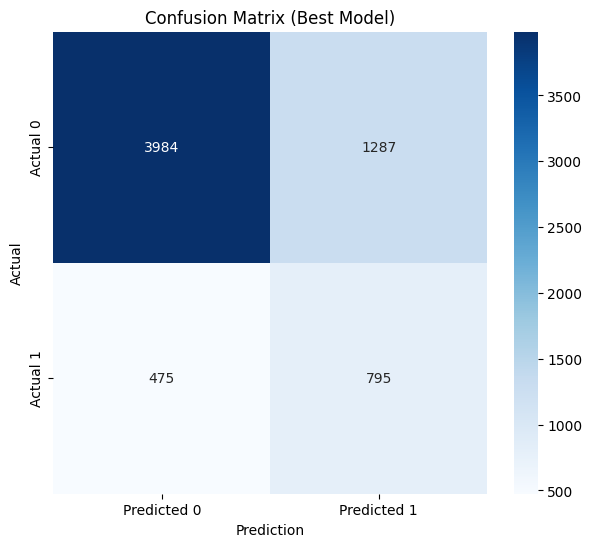

Confusion Matrix plot displayed.


<Figure size 800x700 with 0 Axes>

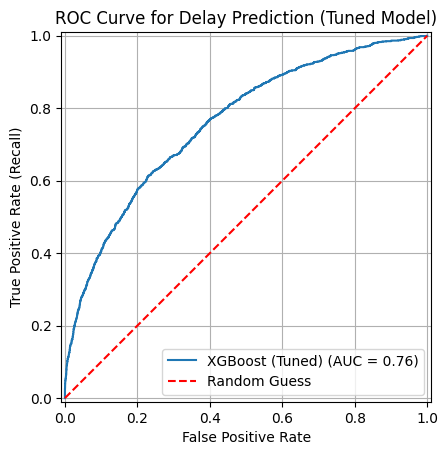

ROC AUC Curve plot displayed.

Test Set ROC AUC Score (Best Model): 0.7599

The full, optimized pipeline is ready for prediction.
Example prediction on first test case: 0 (0=No Delay, 1=Delayed)


In [ ]:

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Delayed (0)', 'Delayed (1)']))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()
print("Confusion Matrix plot displayed.")

# 4. ROC AUC Curve
plt.figure(figsize=(8, 7))
RocCurveDisplay.from_predictions(y_test, y_pred_proba, name='XGBoost (Tuned)')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Diagonal line
plt.title('ROC Curve for Delay Prediction (Tuned Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(True)
plt.show()
print("ROC AUC Curve plot displayed.")

roc_auc = auc(*roc_curve(y_test, y_pred_proba)[0:2])
print(f"\nTest Set ROC AUC Score (Best Model): {roc_auc:.4f}")

print("\nThe full, optimized pipeline is ready for prediction.")



--- STEP D: FEATURE IMPORTANCE ANALYSIS ---


C:\Users\karlt\AppData\Local\Temp\ipykernel_15116\1843484893.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


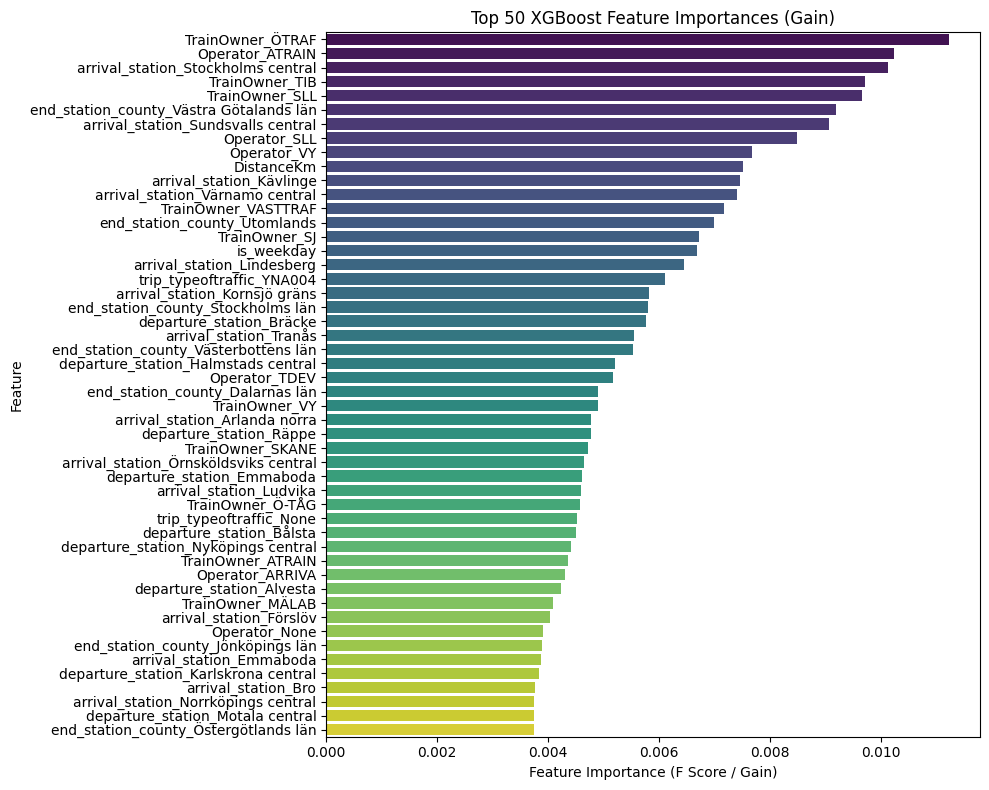

Top 50 Feature Importance plot displayed.


In [12]:
# --- Step D: Feature Importance Visualization ---
print("\n" + "="*50)
print("--- STEP D: FEATURE IMPORTANCE ANALYSIS ---")
print("="*50)

# 1. Get the trained classifier from the best pipeline
final_model = best_model.named_steps['classifier']

# 2. Extract feature names from the ColumnTransformer in the pipeline
# The get_feature_names_out() method provides the final feature names
# in the correct order: num, cat (OHE), bin (passthrough)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# 3. Create a DataFrame for importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Select top 20 features
top_n = 50
top_features = feature_importance_df.head(top_n).copy()

# 5. Clean up feature names for better visualization 
# (Removes prefixes like 'cat__', 'num__', 'bin__')
top_features['Feature'] = top_features['Feature'].str.replace(r'^(cat|num|bin)__', '', regex=True)

# 6. Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} XGBoost Feature Importances (Gain)')
plt.xlabel('Feature Importance (F Score / Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print(f"Top {top_n} Feature Importance plot displayed.")
